### Прасад Роман Задание на стажировку Март 2024 - обучение моделей

Из ноутбука были исключены другие варианты моделей (пайплайнов) ввиду их меньшей эффективности. В данном решении представлен KNN по метрике Минковски для согласованности исходного датасета ```train``` и фичей, где после проверки на корреляцию были удалены повторяющие друг друга признаки и признаки с высокой корреляцией между друг другом. Далее, с помощью Optuna были найдены оптимальные параметры регрессора CatBoost (представлены в словаре внизу ноутбука) с первостепенным учетом метрики MAE и второстепенно - R^2.

In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import optuna
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('submission_sample.csv')
features = pd.read_csv('features.csv')

In [3]:
train.corr()

,id,lat,lon,score
id,1.000000,-0.011370,0.004576,0.005581
lat,-0.011370,1.000000,-0.152755,-0.030629
lon,0.004576,-0.152755,1.000000,0.173265
score,0.005581,-0.030629,0.173265,1.000000


In [4]:
knn = KNeighborsClassifier(n_neighbors=2)
Xknn = features[['lat', 'lon']]

knn.fit(Xknn, np.arange(features.shape[0]))

KNeighborsClassifier(n_neighbors=2)

In [5]:
nearest = knn.predict(train.iloc[:, 1:3])

**Создание датасета для тренировки и часть его анализа:**

In [266]:
features['bound'] = np.arange(features.shape[0])

In [181]:
FULL_TRAIN = pd.merge(train, features, how='left', on='bound').drop(columns=['bound', 'lat_y', 'lon_y'])

Xtrain, Xtest, Ytrain, Ytest = train_test_split(FULL_TRAIN_dropped.drop(columns=['score', 'id']), FULL_TRAIN_dropped['score'],
                                               shuffle=True, random_state=42, test_size=0.25)

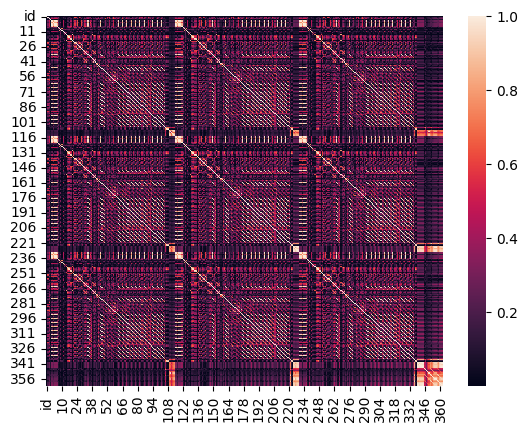

In [186]:
corr_matrix = FULL_TRAIN.corr().abs()

sns.heatmap(corr_matrix);

In [190]:
high_corr_pairs = np.where((corr_matrix > 0.85) & (corr_matrix < 1))

cols_to_drop = set([corr_matrix.columns[x] for x in high_corr_pairs[0]])
cols_to_drop.remove('42')
FULL_TRAIN_dropped = FULL_TRAIN.drop(columns=cols_to_drop)

FULL_TRAIN = pd.merge(train, features, how='left', on='bound').drop(columns=['bound', 'lat_y', 'lon_y'])

Xtrain, Xtest, Ytrain, Ytest = train_test_split(FULL_TRAIN_dropped.drop(columns=['score', 'id']), FULL_TRAIN_dropped['score'],
                                               shuffle=True, random_state=42, test_size=0.25)

In [232]:
with open('cols_to_drop.pkl', 'wb') as f:
    pickle.dump(cols_to_drop, f)

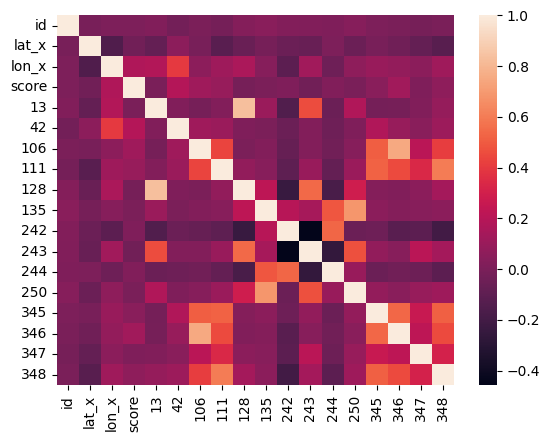

In [180]:
sns.heatmap(FULL_TRAIN_dropped.corr());

**Feature Importance**

In [269]:
feature_importance = cb_regr.feature_importances_
features_imp = np.argsort(feature_importance)
Xtest.columns[features_imp].to_list()

['13',
 '128',
 '135',
 '250',
 '243',
 '244',
 '348',
 '111',
 '347',
 '346',
 '106',
 '345',
 '242',
 '42',
 'lat_x',
 'lon_x']

In [270]:
f_df = {Xtest.columns[features_imp].to_list()[i]: feature_importance[features_imp][i]\
        for i in range(len(feature_importance))}

In [271]:
f_df

{'13': 2.5018028103568338e-05,
 '128': 0.0015453914690140896,
 '135': 0.002837412922076669,
 '250': 0.08615131347871881,
 '243': 0.1603963787459373,
 '244': 0.3541020778172832,
 '348': 5.649396850895689,
 '111': 6.1561414485470065,
 '347': 6.555267794801383,
 '346': 7.5626655133628535,
 '106': 8.183703794951422,
 '345': 8.62969560069566,
 '242': 9.829895123280489,
 '42': 13.828199749251743,
 'lat_x': 16.220892795698017,
 'lon_x': 16.779083736054577}

**Optuna objective:**

In [265]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = catboost.CatBoostRegressor(**params, silent=True)
    model.fit(Xtrain, Ytrain)
    predictions = model.predict(Xtest)
    pred_train = model.predict(Xtrain)
    mae = mean_absolute_error(Ytest, predictions)
    print(f"MAE TRAIN: {mean_absolute_error(Ytrain, pred_train)}")
    print(f"R^2 TEST: {r2_score(Ytest, predictions)}")
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [193]:
A = {'learning_rate': 0.06765430092468332,
 'depth': 10,
 'subsample': 0.772928030827668,
 'colsample_bylevel': 0.8669572881698386,
 'min_data_in_leaf': 41} #сохраняем лучший результат оптюны (params A)

**Test results:**

In [254]:
cb_regr = catboost.CatBoostRegressor(**A)
cb_regr.fit(Xtrain, Ytrain, verbose=False)
Yhat = cb_regr.predict(Xtest)
mean_absolute_error(Ytest, Yhat)

0.04561678580996585

In [255]:
r2_score(Ytest, Yhat)

0.47601944847487754

**Full data results:**

In [267]:
cb_regr = catboost.CatBoostRegressor(**A)
cb_regr.fit(FULL_TRAIN_dropped.drop(columns=['score', 'id']), FULL_TRAIN_dropped['score'], verbose=False)
Yhat = cb_regr.predict(FULL_TRAIN_dropped.drop(columns=['score', 'id']))
mean_absolute_error(FULL_TRAIN_dropped['score'], Yhat)

0.015939072153917384

In [273]:
cb_regr.save_model('classifier') #saving model